# Purpose of this notebook

This notebook is to replicate the Lind paper as we did not do this in the previous notebooks. In particular, we want to look at 

# import the files and functions

In [39]:
# import packages and functions
import numpy as np
import sys
import matplotlib.pyplot as plt
import xarray as xr
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import pandas as pd  # For rolling mean

%run /home/mmurakami/crios_backups/an_helper_functions/prep_grid.py

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



In [40]:
path = "/home/mmurakami/crios_backups/ASTE_270/Pemberton_BarentsSpaper/ASTE_figs/figs/"

In [41]:
dirIn_new = "/scratch3/atnguyen/aste_270x450x180/run_c68v_adxOFF_20022023_capxxN50_it0062_pk0000000007_bro/diags/BUDG/"

In [42]:
# # load the landmask
hfac = mygrid['hFacC']
landmsk = hfac[0]
landmsk[np.isnan(landmsk)] = 2
landmsk[landmsk == 1] = np.nan

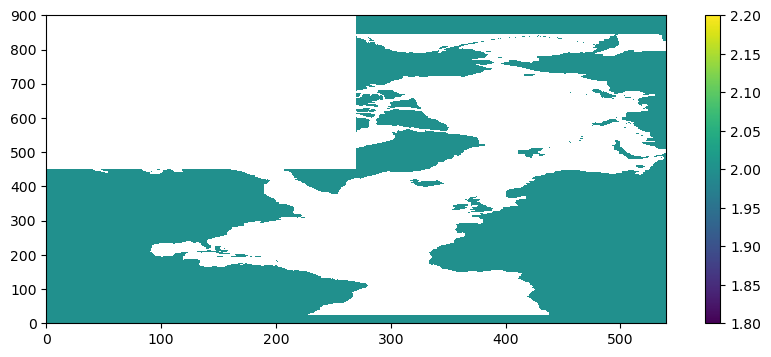

In [47]:
plt.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0])
plt.colorbar()

In [85]:
mymsk = np.load('mask_Lind.npz')
mymsk = mymsk['msk1']
mask = mymsk

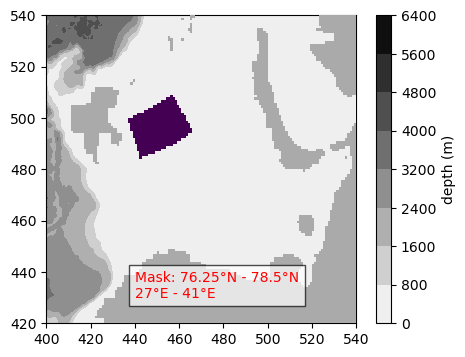

In [82]:
a = np.full(mskBasin.shape,np.nan)
# a[525:555:,35:55] = 1

# create the mask based on lat long
lon = mygrid['XC']
lat = mygrid['YC']
mask = np.zeros_like(lat)
mask[(lat >= 73.25) & (lat <= 80) & (lon >= 20) & (lon <= 55)] = 1  # Masked region
mask[mask == 0 ] = np.nan


fig = plt.figure(figsize=(5,4))

# cb = plt.pcolormesh(get_aste_tracer(mygrid['Depth'],nfx,nfy)[0],cmap="gray_r",vmin=0,vmax=300)
cb = plt.contourf(get_aste_tracer(mygrid['Depth'],nfx,nfy)[0],cmap="gray_r")
plt.colorbar(cb,label="depth (m)")

plt.pcolormesh(get_aste_tracer(mymsk,nfx,nfy)[0],zorder=2)
plt.pcolormesh(get_aste_tracer(hfac,nfx,nfy)[0],zorder=4,cmap="gray_r",vmin=1,vmax=4)

plt.xlim(400,540)
plt.ylim(420,540)

# plt.text(440, 430, "Mask: 73.25°N - 80°N\n20°E - 55°E", color="red", fontsize=10, 
#          bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'),zorder=10)
plt.text(440, 430, "Mask: 76.25°N - 78.5°N\n27°E - 41°E", color="red", fontsize=10, 
         bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'),zorder=10)

plt.savefig(path + "mask_Lind.png",dpi=300)

In [83]:
# check the size of this with RAC
# Lind paper uses a size of 85,000 km^2
RACkm2 = RAC * 1e-6 # km^2
np.nansum(RACkm2*mask)

674018.8948091778

In [84]:
# mymsk = np.load('mask_Lind.npz')
# mymsk = mymsk['msk1']

mymsk = mask

# load this from the file and plot the timeseries of this

In [86]:
# add the isopycnals
# add the density contours from gsw
smin = 25.5 - (0.01 * 25.5)    #salt_ctrl_subregR.min - (0.01 * salt_ctrl_subregR.min)
smax = 36 + (0.01 * 36)    #salt_ctrl_subregR.max + (0.01 * salt_ctrl_subregR.max)
tmin = -2 + (0.1 * -2)       #temp_ctrl_subregR.min - (0.1 * temp_ctrl_subregR.max)
tmax = 31 + (0.1 * 31)       #temp_ctrl_subregR.max + (0.1 * temp_ctrl_subregR.max)
print('tmin, tmax, smin, smax sizes=,', tmin, tmax, smin, smax)
# Calculate how many gridcells we need in the x and y dimensions
xdim = 50
ydim = 50
# Create empty grid of zeros
dens = np.zeros((ydim,xdim))
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(-2,31,ydim)
si = np.linspace(25.5,36,xdim)
Freez_temp = gsw.CT_freezing(si,0,0)

Si, Ti = np.meshgrid(si, ti, sparse=False, indexing='ij')
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        #print(si[i],ti[j])
        dens[j,i]=gsw.rho(si[i],ti[j],0)
        # Substract 1000 to convert to sigma-0
dens2 = dens - 1000

tmin, tmax, smin, smax sizes=, -2.2 34.1 25.245 36.36


In [87]:
# copy the files we need from the timeseries, make sure we know what we're looking at
# get the timesteps for the year 2007
# ocean and ice
AB_gT=0
AB_gS=0
dt_aste = 600
startyr = 2002
endyr = 2019              # for ASTE R1

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)
allyears = np.arange(2003,2018,1)

In [88]:
# np.cumsum(mygrid['DRF'][0:10])
heat_content = np.full((len(allyears),12,ny,nx),np.nan)
fw_content = np.full((len(allyears),12,ny,nx),np.nan)

In [89]:
# loop through the years to create the timeseries
# alldatetimes = np.array([])
# FW_times = np.array([])
# Heat_times = np.array([])  # this does not make sense as variable name
dstart = 0
dterm = 10
# sref = 36.25
# tref = -1.95

# from Lind Paper
sref = 35
tref = 0

iy = 0
for year in allyears:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    # get the theta/salt values
    # we also want salt to do the FW content
    # we want temperature and salt
    THETADR = np.full((len(tsstr),nz,ny,nx),np.nan)
    SALTDR = np.full((len(tsstr),nz,ny,nx),np.nan)
    
    for i in range(len(tsstr)):
    
        # read the fldList
        file_name = 'budg3d_snap_set2'
        meta_budg3d_snap_set2 = parsemeta(dirIn + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_budg3d_snap_set2["fldList"])
        varnames = np.array(["THETADR","SALTDR"])
        recs = np.array([])
        for var in varnames:
            irec = np.where(fldlist == var)
            recs = np.append(recs, irec[0][0])
            
        read = [int(tsstr[i])]
        
        # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
        THETADRi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])  # degC.m
        SALTDRi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[1])  # degC.m
    
        THETADR[i,:,:,:] = np.reshape(THETADRi,(nz,ny,nx))
        SALTDR[i,:,:,:] = np.reshape(SALTDRi,(nz,ny,nx))

    # get theta and salt alone so we can use for the freshwater content
    THETA = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
    SALT = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
    
    for i in range(len(tsstr)):
        THETA[i,:,:,:] = THETADR[i,:,:,:]/DRF3d/mygrid['hFacC']  # degC
        SALT[i,:,:,:]  = SALTDR[i,:,:,:]/DRF3d/mygrid['hFacC']   # PSU

    ##########################################################################################
    # get the heat content
    for i in range(len(datetimes)):
        # for calculating heat content:
            # weighted theta * rcp = J/m^2 which is the depth-weighted heat content of a cell
            # integrate over all values within the depth interval of choice
        
        thisTHETA = THETADR[i]/DRF3d/mygrid['hFacC'] * mymsk[np.newaxis,:,:]    # degC
        thisheat = (thisTHETA - tref) * myparms['rcp']   # degC * J/m^3.degC = J/m^3
        thisheat = thisheat * DRF3d  # J/m³ * m = J/m²

        # select heat based on the AW layer
        thisheat = thisheat[dstart:dterm]   # upper mygrid['DRF'][:dterm] m
        heat_content_2D = np.nansum(thisheat,axis=0) * mymsk         # vertical integration (J/m^2)

        # do the spatial averaging
        # area_masked = RAC * mymsk   # m^2
        # heat_content_avg = np.nansum(heat_content_2D * area_masked)/np.nansum(area_masked)   # MJ/m^2 * m^2/m^2
        heat_content[iy,i,:,:] = heat_content_2D * 1e-6  # MJ/m^2

    ##########################################################################################
    # get the freshwater content values
    # set up for time averaging
    # filter = drf3d.copy() * mygrid['hFacC']
    # filter[filter >= 254] = np.nan
    # filter[filter < 254] = 1
    FWcontent = np.full((len(tsstr),ny,nx),np.nan)
    
    for i in range(len(tsstr)): 
        # for calculating freshwater content:
            # FW volume * (1- salinity/reference salinity)    m^3
            # integrate over surface to mygrid['DRF'][:dterm] m based on the np.where(np.cumsum(mygrid['DRF'])<X meters deep)
            # look at the time average of this
        
        # do step 1 to get FW volume and only look at the values at less than X m
        FWvol = ((sref - SALT[i])/sref) * DRF3d # m
        
        FWvol = FWvol[dstart:dterm]    # leaving as m^3 here
        
        # vertically integrate
        FWcontent_2D = np.nansum(FWvol,axis=0) * mymsk          # vertical integration, m
        # area_masked = RAC * mymsk
        # FW_content_avg = np.nansum(FWcontent_2D * area_masked)/np.nansum(area_masked)

        # add as a map to the bigger array
        fw_content[iy,i,:,:] = FWcontent_2D

    print()
    iy += 1

2003

2004

2005

2006

2007

2008

2009

2010

2011

2012

2013

2014

2015

2016

2017



In [90]:
heat_content_time = np.nanmean(heat_content,axis=(2,3))
fw_content_time = np.nanmean(fw_content,axis=(2,3))

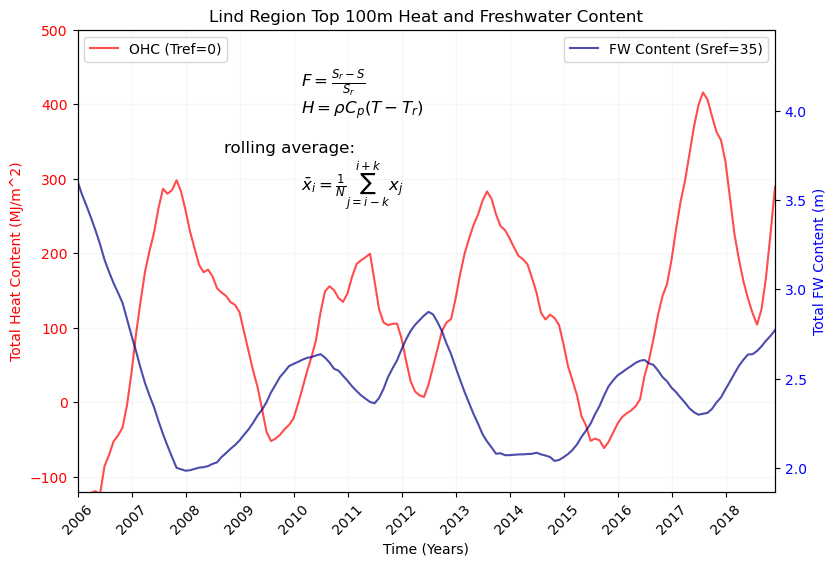

In [94]:

# Define rolling window size (12 months for seasonal smoothing)
window_size = 12

# Apply rolling mean
heat_smoothed = pd.Series(heat_content_time.flatten()).rolling(window=window_size, center=True, min_periods=1).mean()
fw_smoothed = pd.Series(fw_content_time.flatten()).rolling(window=window_size, center=True, min_periods=1).mean()

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(9, 6))

# Time axis
time = np.arange(0, 15*12, 1)

# Plot smoothed heat content on primary y-axis (left)
ax1.plot(time, heat_smoothed, color="red", alpha=.7, label="OHC (Tref=0)")
ax1.set_ylabel("Total Heat Content (MJ/m^2)", color="red")
ax1.tick_params(axis='y', labelcolor="red")

# Create second y-axis for freshwater content (right)
ax2 = ax1.twinx()
ax2.plot(time, fw_smoothed, color="darkblue", alpha=.7, label="FW Content (Sref=35)")
ax2.set_ylabel("Total FW Content (m)", color="blue")
ax2.tick_params(axis='y', labelcolor="blue")

# X-axis labels and title
ax1.set_xlabel("Time (Years)")
ax1.set_title("Lind Region Top 100m Heat and Freshwater Content")

# X-axis ticks
xtick_positions = np.arange(0, 20*12, 12)  # Every 12 months
xtick_labels = np.arange(2004, 2024)  # Years from 2004 to 2023
ax1.set_xticks(xtick_positions)
ax1.set_xticklabels(xtick_labels, rotation=45)  # Rotate for readability
ax1.set_xlim(0, 15*12)
ax1.grid(alpha=0.1)

# Add equations as text annotations
eq1 = r"$F = \frac{S_{r} - S}{S_{r}}$"
eq2 = r"$H = \rho C_p (T - T_{r})$"
eq3 = r"$\bar{x}_i = \frac{1}{N} \sum_{j=i-k}^{i+k} x_j$"  # Rolling mean equation

# Positioning the text on the plot
ax1.text(0.32, 0.92, eq1, transform=ax1.transAxes, fontsize=12, verticalalignment='top', color='black')
ax1.text(0.32, 0.85, eq2, transform=ax1.transAxes, fontsize=12, verticalalignment='top', color='black')
ax1.text(0.21,0.76,"rolling average:",transform=ax1.transAxes, fontsize=12, verticalalignment='top', color='black')
ax1.text(0.32, 0.72, eq3, transform=ax1.transAxes, fontsize=12, verticalalignment='top', color='black')  # Adjusted position


# Legends
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

ax1.set_ylim(-120,500)
ax1.set_xlim(24,time[-1])

# Show plot
plt.savefig(path + "timeseries_OHC_Lind_smaller.png",dpi=300)
plt.show()

# ASTE figure 10

In [75]:
# do a sample for the first year
THETA.shape

(12, 50, 1350, 270)

In [92]:
path

'/home/mmurakami/crios_backups/ASTE_270/Pemberton_BarentsSpaper/ASTE_figs/figs/'